# Section 3
Create a daily sales forecast by channel for the next 90 days.
- Explain which method you chose and why.
- Explain how you evaluated your results.
- Summarize the accuracy of the forecast.

## Load

In [11]:
import pandas as pd
from datetime import date

# load raw data
df = pd.read_csv(
    'ecom_data.csv',
    dtype={
        'SalesOrder': str,
        'SKU': str,
        'Description': str,
        'UnitPrice': float,
        'CustomerID': int,
        'Channel': str,
        'State': str,
        'Sales': float,
        'Quantity': int
    },
    converters={
        'InvoiceDay': date.fromisoformat
    })

# drop duplicates
df.drop_duplicates(inplace=True)

# restrict to sales
df = df[df.Quantity > 0].reset_index(drop=True)

## Initial Thoughts

Before diving into modeling, let's re-examine the 10 day rolling average for daily sales by channel.

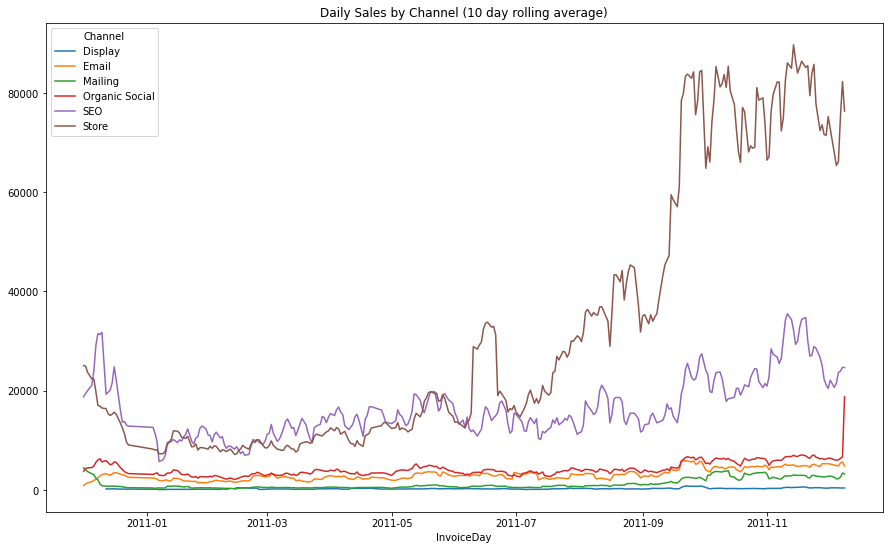

In [2]:
df_rolling = df.groupby(['Channel', 'InvoiceDay'])\
                .agg({'Sales': 'sum'})\
                .rolling(10)\
                .mean()\
                .dropna()

df_rolling.reset_index(drop=False)\
    .pivot(index='InvoiceDay', columns='Channel', values='Sales')\
    .plot(figsize=(15, 9), title="Daily Sales by Channel (10 day rolling average)");

We can tell that there's a clear upward trend for store and mailing sales, while it's less clear if the other channels exhibit upward sales growth.

Because of the clear differences in sales per channel, we'll want to consider using a hierarchical model to forecast sales - one model for each channel, whose results we could aggregate to an overall sales forcast.

Given the limited nature of the dataset and its relatively small time window (less than 1 years' worth of data isn't enough to find an accurate estimate for the seasonal effect), we'll take a simple approach and fit a sinusoidal curve with a linear trend that should reasonably project sales for the next 90 days.

While we could try to use a more complex model like SARIMAX for our forecast, there simply isn't enough data to justify it. Let's create the function and plot a fitted curve (note that we'll keep using `Store` sales for now).

We'll use `scipy.optimize.curve_fit` to fit our curve, and we'll use MAPE and RMSE to measure how well it fits the data. `scipy.optimize.curve_fit` uses non-linear least squares to fit a function, which is what we want as we're fitting a curve. MAPE and RMSE are common measures of model fit, and we'll use them to compare how well different curves fit the data.

In [3]:
import numpy as np
from scipy import optimize

def curve_func(x, amp, freq, phase, trend):
    """Function for a sinusoidal curve with a linear trend component.
    
    ARGS
    - amp: Amplitude of wave.
    - freq: Frequency of wave.
    - phase: Phase shift of wave.
    - trend: Linear trend component.
    
    RETURN
    - Point along the curve given the args above.
    
    """
    return amp * np.sin(freq * x + phase) + trend * x

def fit_curve_func(x, y, p0=[1,1,0,0], curve_func=curve_func):
    """Get parameters, MAPE and RMSE for optimize.curve_fit(curve_func, x, y, p0).
    
    ARGS
    - x: The independant variable.
    - y: The dependant variable.
    - p0: Initial values for the curve_func parameters.
    - curve_func: The curve function to fit.
    
    RETURN
    - dict of parameters, MAPE and RMSE.
    
    """
    # fit curve, get params
    params, params_covariance = optimize.curve_fit(curve_func, x, y, p0=p0)
    
    # get fitted values
    y_hat = [curve_func(i, *params) for i in x]
    
    # calculate MAPE
    mape = np.mean(np.abs((y - y_hat) / y_hat)) * 100
    
    # calculate RMSE
    rmse = np.mean((y - y_hat) ** 2)
    
    return {'params': params, 'MAPE': mape, 'RMSE': rmse}

MAPE: 82.51
RMSE: 612130743.77


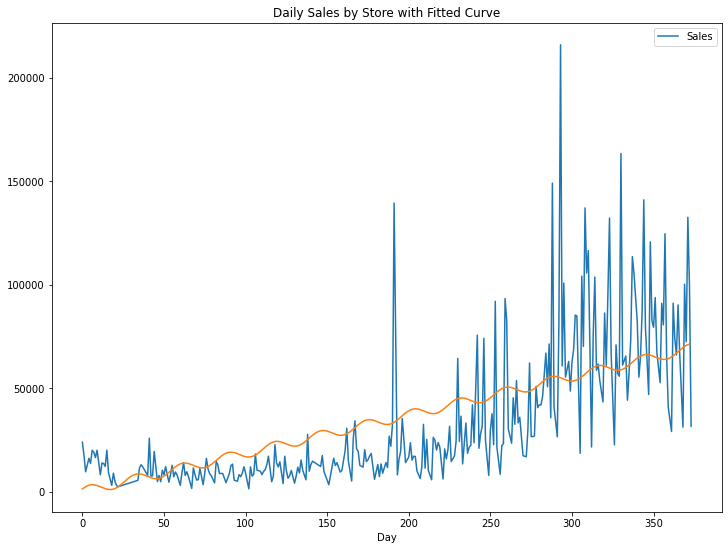

In [4]:
# get sales by store
df_store = df[df.Channel == 'Store']\
    .groupby('InvoiceDay')\
    .agg({'Sales': 'sum'})\
    .reset_index(drop=False)

# add Day column (account for missing date values)
df_store['Day'] = df_store.InvoiceDay.apply(lambda d: (d - df_store.InvoiceDay.min()).days)

# set params
x = df_store.Day.values
y = df_store.Sales

# fit curve, get parameters and accuracy measures
results = fit_curve_func(x, y)

# plot sales, predicted values
print(f"MAPE: {round(results['MAPE'], 2)}")
print(f"RMSE: {round(results['RMSE'], 2)}")
ax = df_store.plot(x='Day', figsize=(12, 9))
ax.set_title("Daily Sales by Store with Fitted Curve")
ax.plot([curve_func(i, *results['params']) for i in range(0, 373)]);

Doesn't look great. We should tune our parameters some to find a better fit. We'll use grid search on a small number of parameters to find a better curve:

In [22]:
from sklearn.model_selection import ParameterGrid

# setup grid
params_grid = {
    'amp': [-100000, -10000, -1000, -100, 0, 100, 1000, 10000, 100000],
    'freq': [-1, -.1, 0, .1, 1],
    'phase': [-10000, -1000, -100, 0, 100, 1000, 10000],
    'trend': [0, 100, 1000]
}

class CurveModel(object):
    """Class to create a model for sales by channel using curve_func and fit_curve_func. 
    
    INITIAL ARGS
    - df: DataFrame of sales data.
    - channel: Name of channel to model.
    - curve_func: Curve function for model.

    """
    
    def __init__(self, df, channel):
        self.channel = channel
        self.best_fit = None
        
        # filter sales to channel, set index to day from start of dataset
        self.df = df[df.Channel == channel].copy()

        # add Day value (number of days from start of InvoiceDay range)
        # accounts for missing values in time when using index values to model
        min_day = df.InvoiceDay.min()
        self.df['Day'] = self.df.InvoiceDay.apply(lambda d: (d - min_day).days)
        self.df = self.df\
            .groupby(['Day'])\
            .agg(({'Sales': 'sum'}))
        
    def fit(self, params_grid=params_grid, debug=False):
        """Use grid search to fit curve_func to sales data.
        
        ARGS
        - params_grid: Parameter grid to use for grid search.
        
        """
        x = self.df.index.values
        y = self.df.Sales
        
        results = []
        for params in ParameterGrid(params_grid):
            try:
                result = fit_curve_func(x,y,list(params.values()))
                results.append(result)
            except RuntimeError:
                # NOTE: scipy will throw a RuntimeError if Optimal parameters cannot be found.
                #       Only happens with some parameter combinations.
                if debug:
                    print(f"Failed to fit params: {params}")
            
        # get params for best fit by RMSE
        results.sort(key=lambda r: r['RMSE'])
        self.best_fit = results[0]
        
    def predict(self, start: int, end: int):
        """Use parameters from fitted curve to predict values from start to end.
        
        - start: Start of prediction range, in days.
        - end: End of prediction range, in days.
        
        """
        if self.best_fit is None:
            print("Model not fitted.")
        else:
            return [curve_func(i, *self.best_fit['params']) for i in range(start, end)]

MAPE: 40.71
RMSE: 476075492.08
Params:
    amp:	17267.6199
    freq:	0.0155
    phase:	-9994.3542
    trend:	180.7873


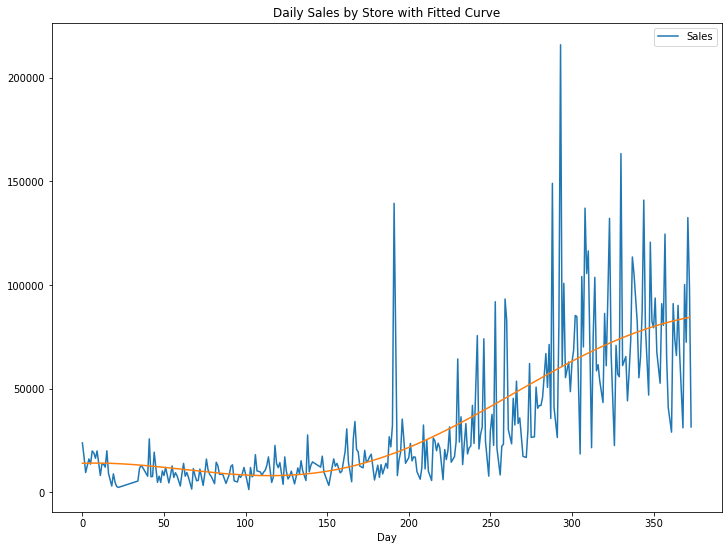

In [23]:
store_model = CurveModel(df, 'Store')
store_model.fit()
best_fit = store_model.best_fit

# print accuracy metrics, params
print(f"MAPE: {round(best_fit['MAPE'], 2)}")
print(f"RMSE: {round(best_fit['RMSE'], 2)}")
print(f"Params:")
for k,v in zip(params_grid.keys(), best_fit['params']):
    print(f"    {k}:\t{round(v, 4)}")

# plot data and curve
ax = df_store.plot(x='Day', figsize=(12, 9))
ax.set_title("Daily Sales by Store with Fitted Curve")
ax.plot(store_model.predict(0, 373));

That looks much better, and our accuracy metrics have improved by a large margin. Let's extend the curve to our 90 day forecast window to see if it behaves as expected:

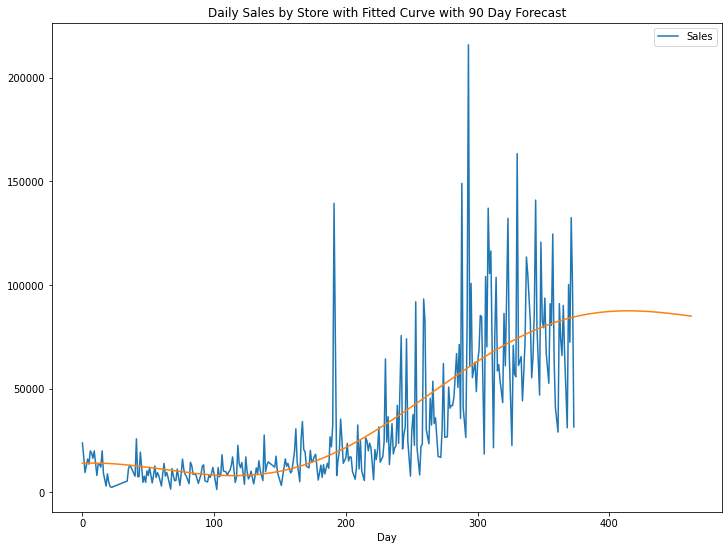

In [24]:
# plot data and curve with forecast
ax = df_store.plot(x='Day', figsize=(12, 9))
ax.set_title("Daily Sales by Store with Fitted Curve with 90 Day Forecast")
ax.plot(store_model.predict(0, 463));

Much better! The curve exhibits a downward trend throughout the winter months, which is the seasonal trend we expect given the downward trend at the start of our dataset.

Let's try it for the other channels.

In [25]:
# create model for each channel
channel_models = {'Store': store_model}
for channel in ['Mailing', 'Organic Social', 'Display','Email', 'SEO']:
    model = CurveModel(df, channel)
    model.fit()
    channel_models[channel] = model

/Users/robert/.pyenv/versions/3.8.2/envs/comoto_takehome/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


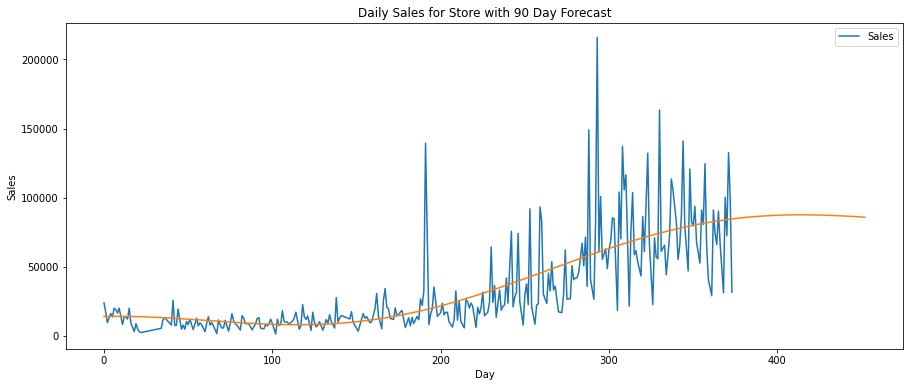

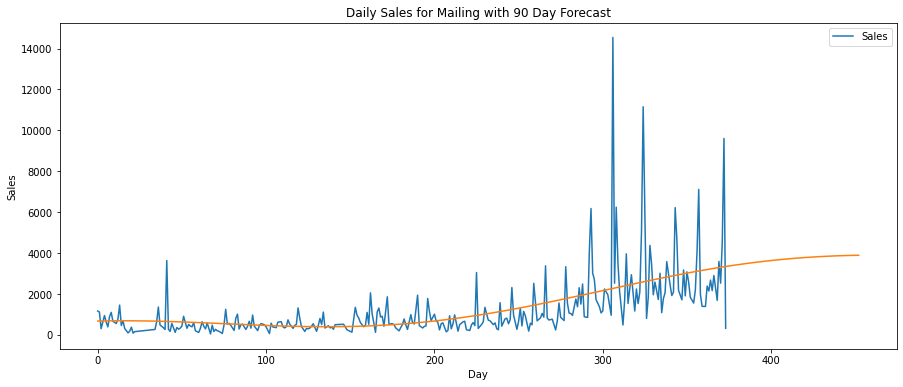

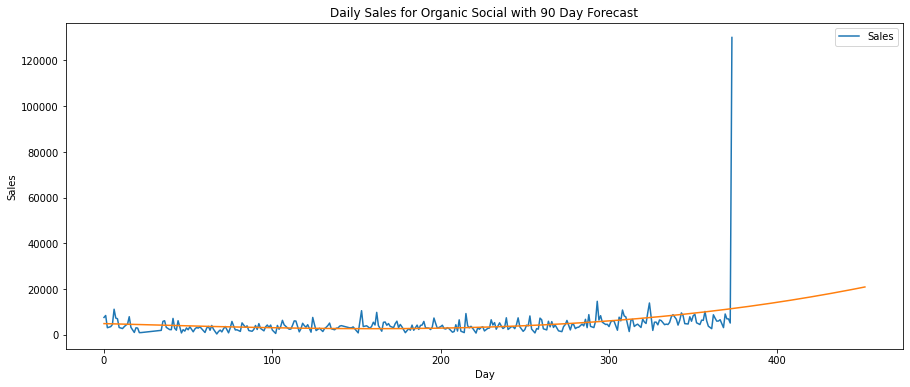

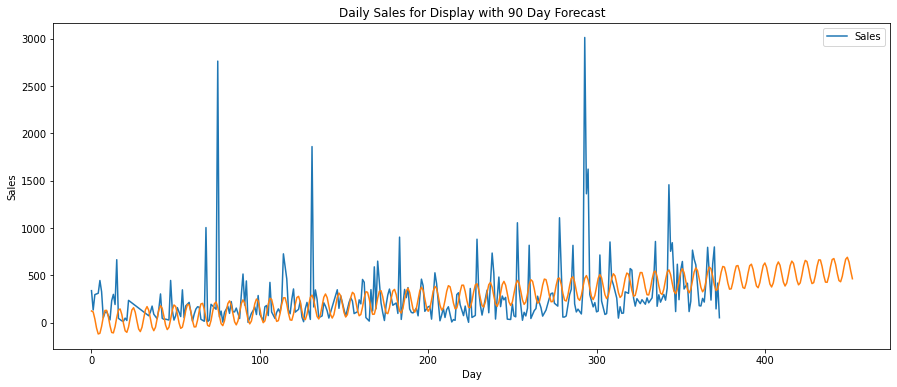

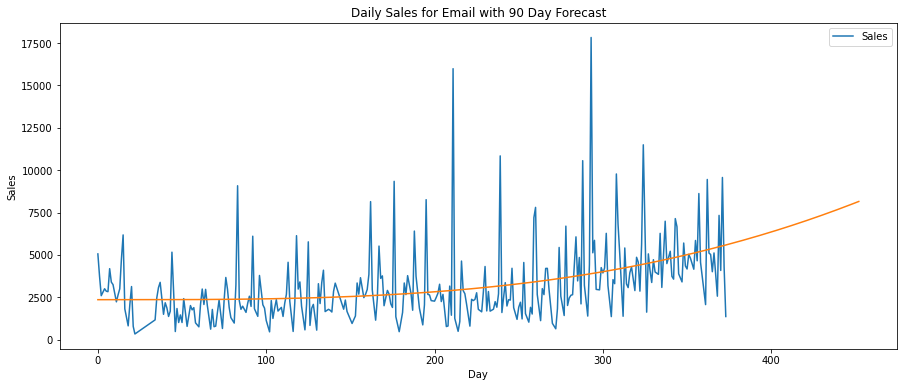

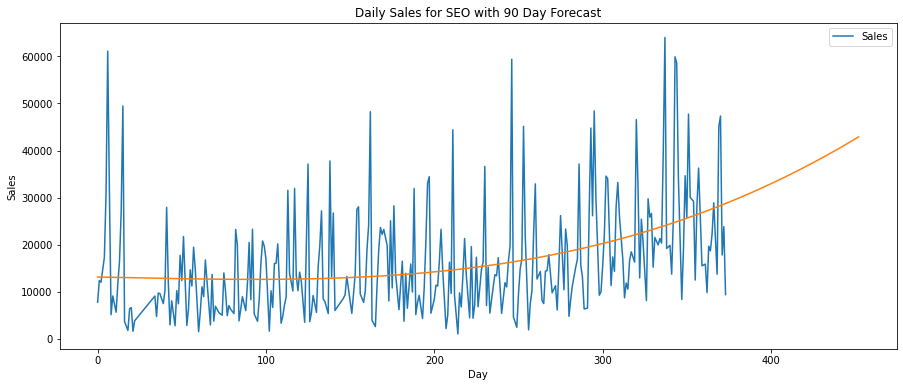

In [50]:
# plot forecasts for each model
for channel, model in channel_models.items():
    ax = model.df.plot(figsize=(15, 6))
    ax.set_title(f"Daily Sales for {channel} with 90 Day Forecast")
    ax.set_ylabel("Sales")
    ax.plot(model.predict(0, 453))
    ax.get_figure().savefig(f"images/sales_forecast_for_{channel}.png")

Not bad, though the models for SEO, Email, and Organic social could use work. They should inflect downwards at the end of the year to reflect seasonality, but instead arc up. Let's take a look at the accuracy metrics:

In [41]:
for channel, model in channel_models.items():
    print(channel)
    print(f"MAPE: {round(model.best_fit['MAPE'], 2)}")
    print(f"RMSE: {round(model.best_fit['RMSE'], 2)}\n")

Store
MAPE: 40.71
RMSE: 476075492.08

Mailing
MAPE: 52.87
RMSE: 1564331.82

Organic Social
MAPE: 44.01
RMSE: 51833801.34

Display
MAPE: 139.12
RMSE: 102996.72

Email
MAPE: 42.94
RMSE: 4257439.54

SEO
MAPE: 51.05
RMSE: 117967846.44



It's interesting that the MAPE for Display is higher than the other channels. The other metrics here don't say much, but it's clear that most of the models could use some work. With tuning, they could fit better, but in the interest of time we'll move on.

In [49]:
# aggregate forecasts for 90 day period
forecasted_sales = 0
for channel, model in channel_models.items():
    forecast = model.predict(373, 463)
    forecasted_sales += sum(forecast)
    
# get percent increase over period from 2011
previous_sales = df[df.InvoiceDay < date.fromisoformat('2011-03-08')].Sales.sum()

print(f"Sales for period in 2010-2011: {previous_sales}")
print(f"Forecasted sales for next period: {forecasted_sales}")
print(f"Percent increase: {round(forecasted_sales / previous_sales, 4) * 100}%")

Sales for period in 2010-2011: 2087206.29
Forecasted sales for next period: 13562277.427724037
Percent increase: 649.78%


That's too high, and that's further evidence the models needs more work. Just looking at the data, I'd have expected to see something in the 300-500% range.

## Summary

Given the limited nature of the dataset and its relatively small time window (less than 1 years' worth of data isn't enough to find an accurate estimate for the seasonal effect), I used a sinusoidal curve with a linear trend to create a simple forecast function that should reasonably project sales for the next 90 days for each channel.

Though the final models don't all reflect the seasonal trend as accurately as I'd hoped, the better fitting ones show that the approach shows promise and that the models could improve given more tuning.

While the forecast shows a 650% increase in year-over-year sales for the 90 day window, I think that's optimistic, and I would have expected to see something in the 300-500% range. 